In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler

#### Path where entire data is located

In [3]:
data_path = 'contours'

#### A method to split train and test datasets and generate loaders

In [6]:
def train_test_split(data_dir, validation_size=0.2):
    transform = transforms.Compose(
        [transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    data = datasets.ImageFolder(root=data_dir, transform=transform)
    num_train = len(data)
    indices = list(range(num_train))
    test_size = int(np.floor(validation_size * num_train))
    np.random.shuffle(indices)
    
    train_indices, test_indices = indices[test_size:], indices[:test_size]
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    
    train_loader = torch.utils.data.DataLoader(data, sampler=train_sampler, batch_size=32)
    test_loader = torch.utils.data.DataLoader(data, sampler=test_sampler, batch_size=32)
    return train_loader, test_loader

In [7]:
train_loader, test_loader = train_test_split(data_path, validation_size=0.3)

#### Classes for the dataset

In [8]:
classes = train_loader.dataset.classes
classes

['fist', 'left', 'ok', 'open_palm', 'right']

### Display sample images from the dataset

In [9]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [11]:
labels

tensor([3, 1, 4, 3, 0, 3, 3, 0, 1, 2, 2, 3, 2, 1, 1, 0, 1, 3, 0, 1, 4, 0, 0, 0,
        4, 2, 2, 1, 0, 3, 1, 2])

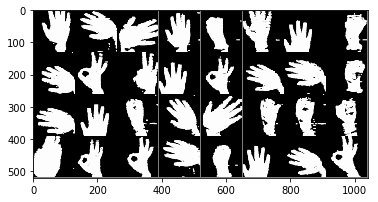

open_palm, left, right, open_palm, fist, open_palm, open_palm, fist, left, ok, ok, open_palm, ok, left, left, fist, left, open_palm, fist, left, right, fist, fist, fist, right, ok, ok, left, fist, open_palm, left, ok


In [12]:
# Displays one random batch of images
imshow(torchvision.utils.make_grid(images))
print(', '.join([classes[labels[j]] for j in range(32)]))

In [13]:
images[0].shape

torch.Size([3, 128, 128])

### Define a Convolutional Network

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*29*29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*29*29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
net = Net()

### Define a loss function and optimizer

In [17]:
import torch.optim as optim

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [19]:
epochs = 2
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero out the parameter gradients
        optimizer.zero_grad()
        
        # Forward + Backward + Optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Stats
        running_loss += loss.item()
        if i % 10 == 9:
            # Print every 10 mini-batches
            print('[Epoch: {0}, Batch: {1}] Loss: {2}'.format(epoch+1, i+1, running_loss/10))
            running_loss = 0.0

print('Finished Training...!!')

[Epoch: 1, Batch: 10] Loss: 2.2986353158950807
[Epoch: 1, Batch: 20] Loss: 2.1743529081344604
[Epoch: 1, Batch: 30] Loss: 1.8308737993240356
[Epoch: 1, Batch: 40] Loss: 1.4812711358070374
[Epoch: 1, Batch: 50] Loss: 1.252336037158966
[Epoch: 1, Batch: 60] Loss: 1.0185435116291046
[Epoch: 2, Batch: 10] Loss: 0.7879684686660766
[Epoch: 2, Batch: 20] Loss: 0.6287210345268249
[Epoch: 2, Batch: 30] Loss: 0.61012042760849
[Epoch: 2, Batch: 40] Loss: 0.5171917527914047
[Epoch: 2, Batch: 50] Loss: 0.5441637873649597
[Epoch: 2, Batch: 60] Loss: 0.4672319874167442
Finished Training...!!


#### Save the trained model

In [20]:
torch.save(net.state_dict(), 'contour_model.pth')

## Testing the trained model

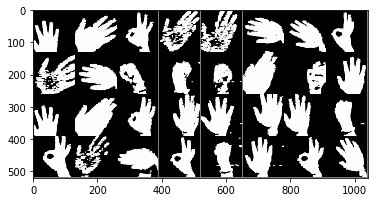

GroundTruth:  open_palm, right, ok, right, right, left, left, ok, right, left, fist, fist, fist, right, fist, open_palm, open_palm, right, ok, open_palm, open_palm, open_palm, open_palm, fist, ok, right, left, ok, fist, open_palm, ok, left


In [21]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join([classes[labels[j]] for j in range(32)]))

### Load the model

In [22]:
net = Net()
net.load_state_dict(torch.load('contour_model.pth'))

<All keys matched successfully>

In [31]:
images.shape

torch.Size([4, 3, 128, 128])

In [23]:
outputs = net(images)

In [24]:
_, predicted = torch.max(outputs, 1)

In [25]:
predicted

tensor([3, 4, 2, 4, 4, 1, 1, 2, 4, 1, 0, 0, 0, 4, 2, 3, 4, 4, 2, 3, 3, 3, 3, 0,
        2, 4, 1, 2, 0, 3, 2, 1])

In [26]:
print('Predicted: ', ', '.join([classes[predicted[j]] for j in range(32)]))

Predicted:  open_palm, right, ok, right, right, left, left, ok, right, left, fist, fist, fist, right, ok, open_palm, right, right, ok, open_palm, open_palm, open_palm, open_palm, fist, ok, right, left, ok, fist, open_palm, ok, left


### Check how the model performs on the whole dataset

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy = {}'.format(100 * correct / total))

Accuracy = 89.66666666666667


### Test how the model performed for different classes

In [28]:
class_correct = list(0 for i in range(5))
class_total = list(0 for i in range(5))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        batch_size = min(32, len(images))
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
            
for i in range(5):
    print('Accuracy of {}: {}'.format(classes[i], 100*class_correct[i]/class_total[i]))
    

Accuracy of fist: 75.97765363128492
Accuracy of left: 98.34254143646409
Accuracy of ok: 93.85474860335195
Accuracy of open_palm: 84.0
Accuracy of right: 95.6989247311828


### Training on GPU

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')